In [1]:
#Used to make data more uniform across screen.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
#Import packages used here:
# for initial data exploration:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display
import random
import math

#For modeling and model viewing. 
import tensorflow as tf
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical #Image generator used for transformation to categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras import backend, models
#from sklearn.model_selection import train_test_split  #could have used on the consolidated file.
from sklearn.metrics import confusion_matrix

from tensorflow.keras.applications import VGG16, MobileNet
#from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input

In [3]:
#This will setup my directories for all of the data files in the 100-bird-species dataset. 
BASE_DIR = 'dataset'
print('BASE_DIR contains ', os.listdir(BASE_DIR))
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALIDATION_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

BASE_DIR contains  ['valid', '.DS_Store', 'test', 'train']


In [4]:
#This will establish the prediction groups for the model.
CATEGORIES = os.listdir(TRAIN_DIR)

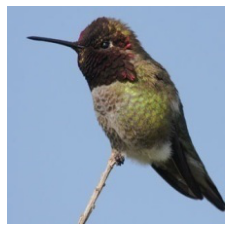

Figures are  (224, 224, 3)


In [5]:
#Load an image and determine image shape for analysis.
IMAGE = load_img("dataset/train/ANNAS HUMMINGBIRD/025.jpg")
plt.imshow(IMAGE)
plt.axis("off")
plt.show()

IMAGEDATA = img_to_array(IMAGE)
SHAPE = IMAGEDATA.shape
print('Figures are ', SHAPE)

In [6]:
#This will be used on training, test, and valid data
General_datagen = ImageDataGenerator(rescale=1./255, )

In [7]:
train_data = General_datagen.flow_from_directory(TRAIN_DIR, target_size=(224,224))
print('data groups:', len(train_data)) #Will be used to determine steps_per_epoch in my models.
Train_groups = len(train_data)
print(Train_groups)
validation_data = General_datagen.flow_from_directory(VALIDATION_DIR, target_size=(224,224),)
image_qty = len(validation_data.filenames)
print('data groups:', len(validation_data))
print('validation image qty:',str(image_qty))
Valid_groups = len(validation_data)
test_data = General_datagen.flow_from_directory(TEST_DIR, target_size=(224,224),)
print('data groups:', len(test_data))

Found 35215 images belonging to 250 classes.
data groups: 1101
1101
Found 1250 images belonging to 250 classes.
data groups: 40
validation image qty: 1250
Found 1250 images belonging to 250 classes.
data groups: 40


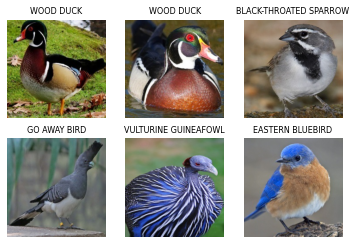

In [8]:
#create seperate labels for images 
def label_images2(DIR, dataset):
    label = []
    image = []
    j=0
    for i in range (0,30):
        j = random.randint(0, len(dataset.filenames))
        label.append(dataset.filenames[j].split('/')[0])
        image.append(DIR + '/' + dataset.filenames[j])
    return [label,image]

#plot the random images.
y,x = label_images2(TEST_DIR, test_data)

for i in range(0,6):
    X = load_img(x[i])
    plt.subplot(2,3,+1 + i)
    plt.axis(False)
    plt.title(y[i], fontsize=8)
    plt.imshow(X)
plt.show()

# -----------------------------------

In [9]:
#Let's try the mobilenet with ReduceLROnPlateau - 93% accuracy
backend.clear_session()

#Bring in the imagenet dataset training weights for the Mobilenet CNN model.
#Remove the classification top.
base_mobilenet = MobileNet(weights = 'imagenet', include_top = False, 
                           input_shape = SHAPE)
base_mobilenet.trainable = False # Freeze the mobilenet weights.

model = Sequential()
model.add(base_mobilenet)
model.add(Conv2D(16,(2,2),input_shape=(224,224,3),padding='same'))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Flatten())
model.add(Dense(32*32))
model.add(Dropout(0.5))
model.add(Dense(250))
model.add(Activation('softmax'))
model.summary()

#Compile
model.compile(Adam(0.01),loss = 'categorical_crossentropy',metrics = ['accuracy'])

# ------------------------------------------------------------------------------------------------------

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from datetime import datetime

mc = ModelCheckpoint('best_model_projeto3.h5', monitor='val_loss', mode='min', save_best_only=True)

# ------------------------------------------------------------------------------------------------------

#fit model
history = model.fit_generator( 
    train_data, 
    steps_per_epoch = Train_groups, 
    epochs = 50,
    validation_data = validation_data,
    validation_steps = Valid_groups,
    verbose = 1,
    callbacks=[EarlyStopping(monitor = 'val_accuracy', patience = 5, 
                             restore_best_weights = True),
               ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, #0.2 to 0.5 dropped to fast 0.7
                                 patience = 2, verbose = 1),
               mc
    ]) 
                # left verbose 1 so I could see the learning rate decay

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 16)          65552     
_________________________________________________________________
activation (Activation)      (None, 7, 7, 16)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              263168    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

/Users/joaonunoabreu/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1101/1101 [==============================] - 928s 842ms/step - loss: 40.1003 - accuracy: 0.0226 - val_loss: 62.2647 - val_accuracy: 0.1376
Epoch 2/50
1101/1101 [==============================] - 924s 839ms/step - loss: 81.6037 - accuracy: 0.1600 - val_loss: 71.8419 - val_accuracy: 0.3152
Epoch 3/50
1101/1101 [==============================] - 834s 758ms/step - loss: 103.6842 - accuracy: 0.2487 - val_loss: 76.8892 - val_accuracy: 0.3568

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.006999999843537807.
Epoch 4/50
1101/1101 [==============================] - 897s 815ms/step - loss: 89.0718 - accuracy: 0.3233 - val_loss: 47.8714 - val_accuracy: 0.4928
Epoch 5/50
1101/1101 [==============================] - 961s 873ms/step - loss: 69.7919 - accuracy: 0.3996 - val_loss: 48.1545 - val_accuracy: 0.4992
Epoch 6/50
1101/1101 [==============================] - 924s 839ms/step - loss: 67.7065 - accuracy: 0.4086 - val_loss: 48.9765 - val_accuracy: 0.5168

Epoch 00006: ReduceLROnPlatea

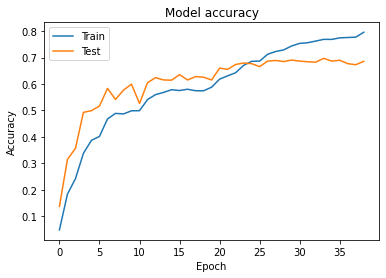

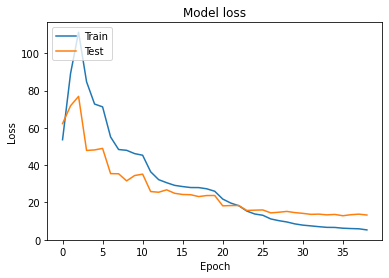

40/40 [==============================] - 24s 606ms/step - loss: 11.6598 - accuracy: 0.6968
Test loss: 11.659765243530273
Test accuracy: 0.6967999935150146


In [11]:
#plot accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss values vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate against test data.
scores = model.evaluate(test_data, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [12]:
dic=train_data.class_indices
icd={k:v for v,k in dic.items()}
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict_classes(img)
    probability=round(np.max(model.predict_proba(img)*100),2)
    print (probability, ' % chances are there that the Bird Is',icd[answer[0]])

100.0  % chances are there that the Bird Is BANANAQUIT


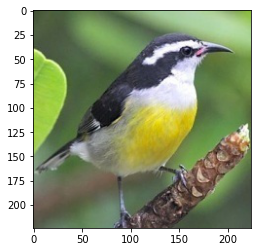

In [33]:
img="dataset/valid/BANANAQUIT/4.jpg"
pic=load_img(img,target_size=(224,224,3))
plt.imshow(pic)
output(img)

In [14]:
np.save('my_history2.npy',history.history)

In [15]:
history2=np.load('my_history2.npy',allow_pickle='TRUE').item()

In [24]:
# Para não ter que correr o model.fit de novo
import h5py
from keras.models import load_model
model = load_model('best_model_projeto3.h5')

In [25]:
dic=train_data.class_indices
icd={k:v for v,k in dic.items()}
def output2(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict_classes(img)
    probability=round(np.max(model.predict_proba(img)*100),2)
    return (probability,icd[answer[0]],location.replace("dataset/valid/",""))

# Classificação de todas as aves

In [27]:
import os

folder = "dataset/valid/"
paths = [os.path.join(root,filename) for root, directories, filenames in os.walk(folder) for filename in filenames]

a = []
counter = 0
for img in paths:
    pic=load_img(img,target_size=(224,224,3))
    a.append(output2(img))
    counter += 1
    if(counter % 50 == 0):
        print(f'{counter}/{len(paths)}')

50/1250
100/1250
150/1250
200/1250
250/1250
300/1250
350/1250
400/1250
450/1250
500/1250
550/1250
600/1250
650/1250
700/1250
750/1250
800/1250
850/1250
900/1250
950/1250
1000/1250
1050/1250
1100/1250
1150/1250
1200/1250
1250/1250


## Resultado

Podemos ver abaixo uma lista cuja estrutura é definida da seguinte forma:

- Chance de ser a espécie prevista
- Espécie prevista
- Verdadeira espécie

In [28]:
a_sorted = sorted(a)
print(a_sorted)

[(45.89, 'FLAMINGO', 'JAVAN MAGPIE/5.jpg'), (51.85, 'CALIFORNIA GULL', 'CALIFORNIA GULL/1.jpg'), (52.08, 'BAY-BREASTED WARBLER', 'AMERICAN REDSTART/2.jpg'), (53.5, 'HOUSE FINCH', 'PALILA/1.jpg'), (55.97, 'ARARIPE MANAKIN', 'BALI STARLING/1.jpg'), (55.98, 'HAWAIIAN GOOSE', 'DOWNY WOODPECKER/2.jpg'), (57.05, 'CRESTED CARACARA', 'CRESTED CARACARA/4.jpg'), (57.36, 'BLACK THROATED WARBLER', 'BLACK THROATED WARBLER/5.jpg'), (57.96, 'PAINTED BUNTIG', 'AFRICAN FIREFINCH/4.jpg'), (58.57, 'HELMET VANGA', 'YELLOW BELLIED FLOWERPECKER/2.jpg'), (59.34, 'WHITE CHEEKED TURACO', 'RED FACED WARBLER/5.jpg'), (62.0, 'HORNBILL', 'BLACK SKIMMER/4.jpg'), (62.17, 'VENEZUELIAN TROUPIAL', 'EASTERN MEADOWLARK/1.jpg'), (62.88, 'NORTHERN PARULA', 'AMERICAN REDSTART/1.jpg'), (62.96, 'PINK ROBIN', 'NORTHERN PARULA/2.jpg'), (65.04, 'GOLDEN CHLOROPHONIA', 'CUBAN TODY/3.jpg'), (65.51, 'CALIFORNIA CONDOR', 'BALD EAGLE/2.jpg'), (67.17, 'BLACK THROATED WARBLER', 'BLACK THROATED WARBLER/3.jpg'), (67.97, 'NORTHERN BALD IBI

Há um total de 1250 imagens de validação, 10325 delas o modelo afirmou com 100% de certeza que seriam de determinada espécie.

In [29]:
a = [i[0] for i in a_sorted if(i[0] == 100.0)]
print(len(a))

1025


Das 1250 imagens de validação, o modelo avaliou corretamente 862 (68.96%).

In [30]:
count = 0
for i in a_sorted:
    real_species = i[2].split("/",1)[0]
    predicted_species = i[1]
    if(real_species == predicted_species):
        count += 1

print(count)
print((count / 1250)*100)

862
68.96
